In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import solve_ivp
plt.style.use('ggplot')
plt.style.use('seaborn-poster')


In [2]:
# T_theta = 125 # ms, theta osicillation period
A_STDP = 0.03; s_STDP = 4 # parameters for STDP
omega = lambda dx: A_STDP * np.exp(s_STDP*np.cos(dx)) * np.sin(dx) # gabor as STDP rule
domega = lambda dx: A_STDP * np.exp(s_STDP*np.cos(dx)) * (np.cos(dx) - s_STDP*np.sin(dx)**2) # derivative of STDP in respect to xi (postsynaptic)
# plot STDP and PCF
# u = np.arange(-np.pi,np.pi,np.pi/120)
# plt.plot(u,omega(u))
# plt.plot(u,domega(u))
# plt.plot(u,domega(u)*omega(u))


In [3]:
def mainode(t,x):
    # global variables:
    # N is number of neurons
    # Wij is the synpatic efficancy from neuron j to i
    # sigma2_w is the variance of W
    # x_tilde is the recall cue
    # k_{prior,noise} is the concentration of prior and 
    # cue distribution
    # x_fire is list of each neuron's list of firing 
    # phase, dynamically updated at each event
    # H = np.zeros((N,N))
    # for j in range(N):
    #     if x_fire[j]: # if neuron j has fired
    #         xj = x_fire[j][-1] # we need the last firing phase
    #         dxij = x-xj # phase difference between neurons
    #         H[:,j] = W[:,j] * domega(dxij) # phase interaction
    #                                        # from neuron j
    #                                        # to neuron i
    #                                        # Hjj is guarenteed
    #                                        # to be 0 because
    #                                        # Wjj is 0
    dx_prior    = -k_prior * np.sin(x) 
    dx_external = -k_noise * np.sin(x-x_tilde)
    dx_synapse  = 0 # np.sum(H,1)/sigma2_w # sum_j H_{ij}/sigma_w^2
    return dx_prior + dx_external + dx_synapse


In [4]:
N = 200	# number of neurons
event = [lambda t,x,j=j: np.sin((x[j]-t)/2) for j in range(N)]      
        # event[i](t,x)
        # equals 0 when firing phase
        # of neuron i matches current LFP 
        # i.e. (x[i]-t) mod 2pi ==0   
        # syntax: j=j freeze j google "python define list of function"                              

In [5]:
N = N	# number of neurons
M = 10	# number of memories
k_prior = 0.5	# von Mises concentration parameter
                # for prior distribution
k_noise = 10	# for cue distribution
x_memory = np.random.vonmises(0,k_prior,(N,M)) # every column 
                                        # is a memory trace
W = np.zeros((N,N))
for i in range(N):
    for j in range(i): # j<i, Wii = 0
        for k in range(M): # the STDP rule is additive
            W[i,j] += omega(x_memory[i,k]-x_memory[j,k])
            W[j,i] += omega(x_memory[j,k]-x_memory[i,k])
W_flatten = [W[i][j] for i in range(N) for j in range(i) ]
sigma2_w = np.var(W_flatten)
# plt.hist(W_flatten,50)

In [6]:
kk=0
x_target = x_memory[:,kk].copy()     # the kk'th one is 
                                    # what we want to recall
x_noise = np.random.vonmises(0,k_noise,N)   # indepedent random
                                # noise to corrupt the cue
x_tilde = x_target + x_noise 
x_0 = np.random.vonmises(0,k_prior,N)
x_0 = x_tilde



In [7]:
print(not np.any(np.diag(W)))
i,j = np.random.randint(0,N,2)
print(W[i,j] + W[j,i] == 0)

True
True


In [8]:
# p=np.argmin(np.mod(x_0,2*np.pi))
# print(p)
# print(x_0[p])
# print(x_target[p])
# print(x_tilde[p])

In [9]:
x_fire = [[ ] for j in range(N)] # record firing phase
for func in event: 
        func.terminal = True # stop integration when any neuron fires
# first round
tf = 40*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
print(sol.message)
print(tNow)
# print(len(xNow))

25
A termination event occurred.
0.017402628078456214


In [10]:
# tf += 10*np.pi
while tNow < tf:
        sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
        t = np.append(t,sol.t)          # integrate until one neuron
        x = np.append(x,sol.y,axis=1)   # fires, record time, state,
        tNow = t[-1]                    # firing time and neuron
        xNow = x[:,-1]                  # index
        whoFire = []
        for j,te in enumerate(sol.t_events): 
                event[j].terminal = True 
                if te.size>0:
                        event[j].terminal = False
                        if (not x_fire[j]) or te[0]>x_fire[j][-1]+1e-5: # 'refractory' to prevent overcounting spikes
                                whoFire += [j]
                                x_fire[j] += list(te)  # update x_fire for calculating H
        if 0 in whoFire:
                print(sol.message)
                print(tNow)


A termination event occurred.
3.8306563363371486


A termination event occurred.
10.113841643516114


A termination event occurred.
16.3970269506957


A termination event occurred.
22.680212257875286


A termination event occurred.
28.963397565054873


A termination event occurred.
35.246582872234455


A termination event occurred.
41.52976817941404


A termination event occurred.
47.81295348659363


A termination event occurred.
54.096138793773214


A termination event occurred.
60.3793241009528


A termination event occurred.
66.6625094081324


A termination event occurred.
72.94569471531197


A termination event occurred.
79.22888002249157


A termination event occurred.
85.51206532967115


A termination event occurred.
91.79525063685074


A termination event occurred.
98.07843594403032


A termination event occurred.
104.36162125120991


A termination event occurred.
110.64480655838949


A termination event occurred.
116.92799186556908


A termination event occurred.
123.21117717274866


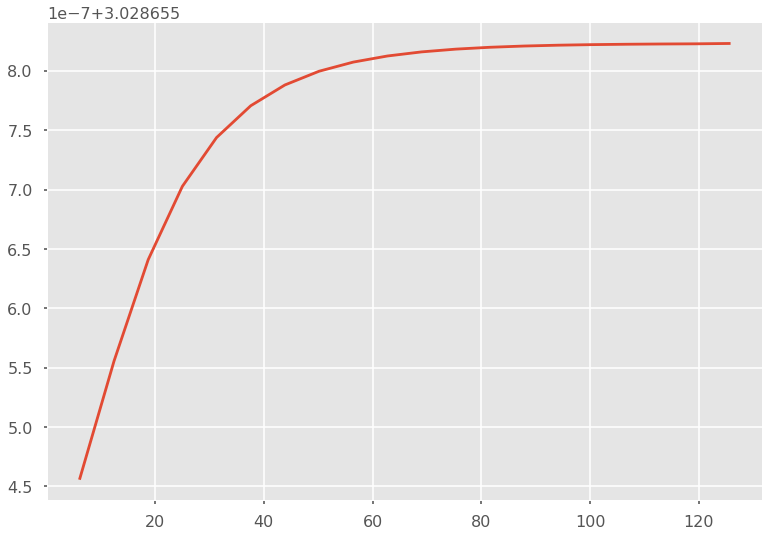

In [11]:
p=65
plt.plot(x_fire[p],np.mod(x_fire[p],(np.pi)))

In [12]:
x_last  = np.array([x_fire[i][-1] for i in range(N)])
x_diff = np.mod(x_last,np.pi*2) - np.mod(xNow, np.pi*2)
print(np.mean(x_diff))
print(np.std(x_diff))

2.749775238680349e-08
3.9928595446527844e-07


In [13]:
x_last2 = np.array([x_fire[i][-2] for i in range(N)])
x_diff = np.mod(x_last - x_last2, np.pi*2)
print(np.mean(x_diff))
print(np.std(x_diff))

3.235840480160582
3.1401785617535065


In [14]:
Z = np.exp(1j*x_tilde) + (k_prior/k_noise)
x_bar = np.angle(Z)
# error = np.mod(x_bar - xNow, np.pi*2)
error = np.mod(x_bar,np.pi*2) - np.mod(xNow, np.pi*2)
print(np.mean(error))
print(np.std(error))


9.102814474415411e-12
5.829990668044887e-11


In [15]:
print(x_last[p]%(np.pi*2))
print(xNow[p]%(np.pi*2))
print(x_bar[p]%(np.pi*2))


6.170248476809412
6.170248476809402
6.170248476809397


In [16]:
x1 = np.random.vonmises(0,k_prior)
x2 = x1 + 20*np.pi + 0.001
print(np.mod(x2-x1, np.pi*2))

0.0010000000000047748


Text(0, 0.5, 'circular MSE')

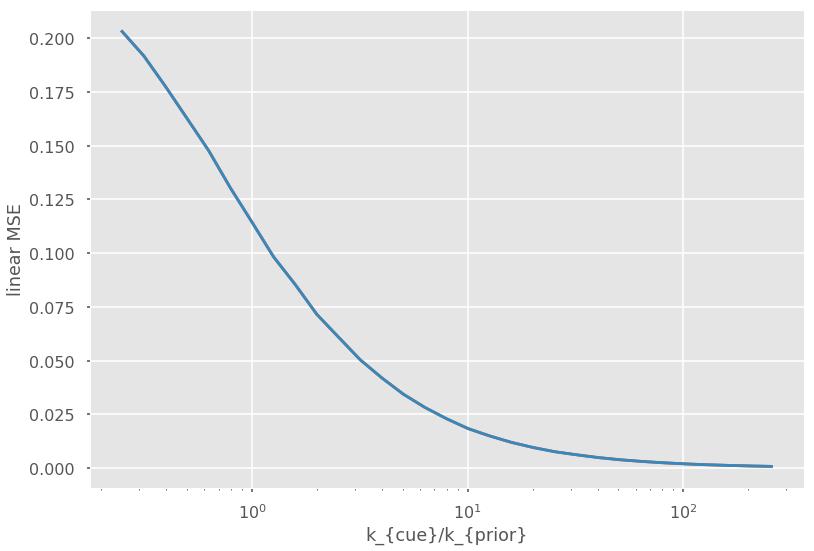

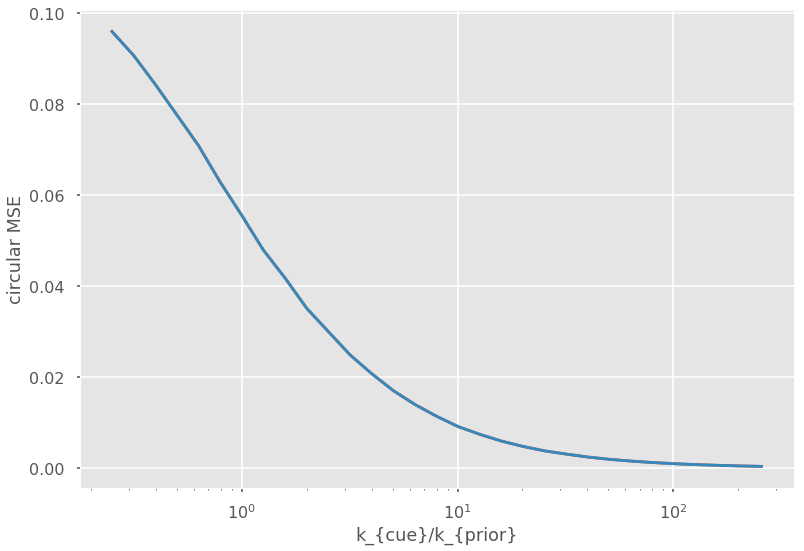

In [17]:
k_prior = 5
kratios = np.logspace(-2,8,31,base=2)
#
NN = int(1e5)
bias = np.zeros_like(kratios)
lvar = np.zeros_like(kratios)
ldsp = np.zeros_like(kratios)
cvar = np.zeros_like(kratios)
cdsp = np.zeros_like(kratios)
#
for ind,k in enumerate(kratios):
    # print(ind)
    x = np.random.vonmises(0,k_prior,NN)
    noise = np.random.vonmises(0,k*k_prior,NN)
    x_tilde = x + noise
    Z = np.exp(1j*x_tilde) + 1/k
    x_bar = np.angle(Z)
    error = x_bar - x
    error = np.mod(error+np.pi,np.pi*2)-np.pi
    # h=plt.hist(error,100,(-np.pi,np.pi),color=cm.YlGn(ind/21),histtype='step')
    bias[ind] = np.mean(error)
    lvar[ind] = np.var(error)
    ldsp[ind] = lvar[ind] + bias[ind]**2
    vR = np.exp(1j*error)
    R = abs(np.mean(vR))
    cvar[ind] = 1 - R
    cdsp[ind] = cvar[ind] + 2*R*(np.sin(bias[ind]/2)**2)
#
plt.figure()
plt.semilogx(kratios,lvar)
plt.semilogx(kratios,ldsp)
plt.xlabel(r'k_{cue}/k_{prior}')
plt.ylabel('linear MSE')
#
plt.figure()
plt.semilogx(kratios,cvar)
plt.semilogx(kratios,cdsp)
plt.xlabel(r'k_{cue}/k_{prior}')
plt.ylabel('circular MSE')

Text(0, 0.5, 'circular MSE')

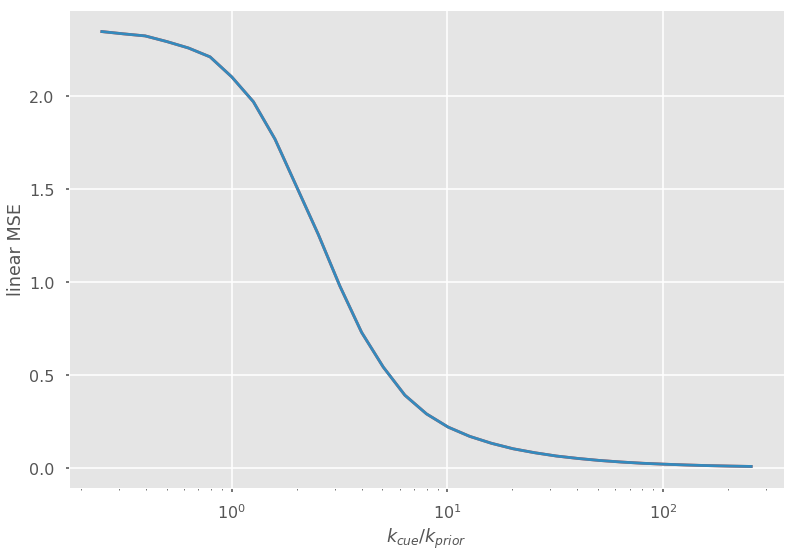

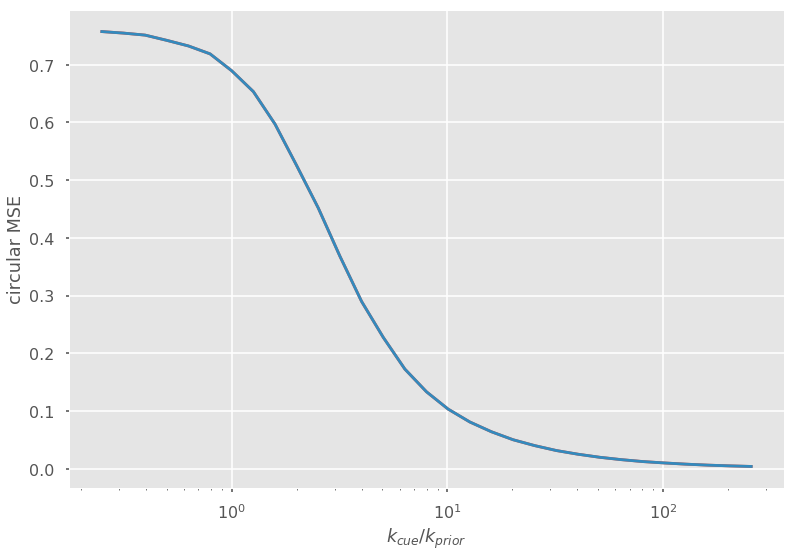

In [18]:
k_prior = .5
kratios = np.logspace(-2,8,31,base=2)
#
NN = int(1e5)
bias = np.zeros_like(kratios)
lvar = np.zeros_like(kratios)
ldsp = np.zeros_like(kratios)
cvar = np.zeros_like(kratios)
cdsp = np.zeros_like(kratios)
#
for ind,k in enumerate(kratios):
    # print(ind)
    x = np.random.vonmises(0,k_prior,NN)
    noise = np.random.vonmises(0,k*k_prior,NN)
    x_tilde = x + noise
    Z = np.exp(1j*x_tilde) + 1/k
    x_bar = np.angle(Z)
    error = x_bar - x
    error = np.mod(error+np.pi,np.pi*2)-np.pi
    # h=plt.hist(error,100,(-np.pi,np.pi),color=cm.YlGn(ind/21),histtype='step')
    bias[ind] = np.mean(error)
    lvar[ind] = np.var(error)
    ldsp[ind] = lvar[ind] + bias[ind]**2
    vR = np.exp(1j*error)
    R = abs(np.mean(vR))
    cvar[ind] = 1 - R
    cdsp[ind] = cvar[ind] + 2*R*(np.sin(bias[ind]/2)**2)
#
plt.figure()
plt.semilogx(kratios,lvar)
plt.semilogx(kratios,ldsp)
plt.xlabel(r'$k_{cue}/k_{prior}$')
plt.ylabel('linear MSE')
#
plt.figure()
plt.semilogx(kratios,cvar)
plt.semilogx(kratios,cdsp)
plt.xlabel(r'$k_{cue}/k_{prior}$')
plt.ylabel('circular MSE')